In [165]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [166]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [189]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, MetaData

In [190]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [191]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
metadata = MetaData()
metadata.reflect(bind=engine)


In [192]:
# View all of the classes that automap found
classes = Base.classes.keys()
print(classes)


['measurement', 'station']


In [193]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [194]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [195]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


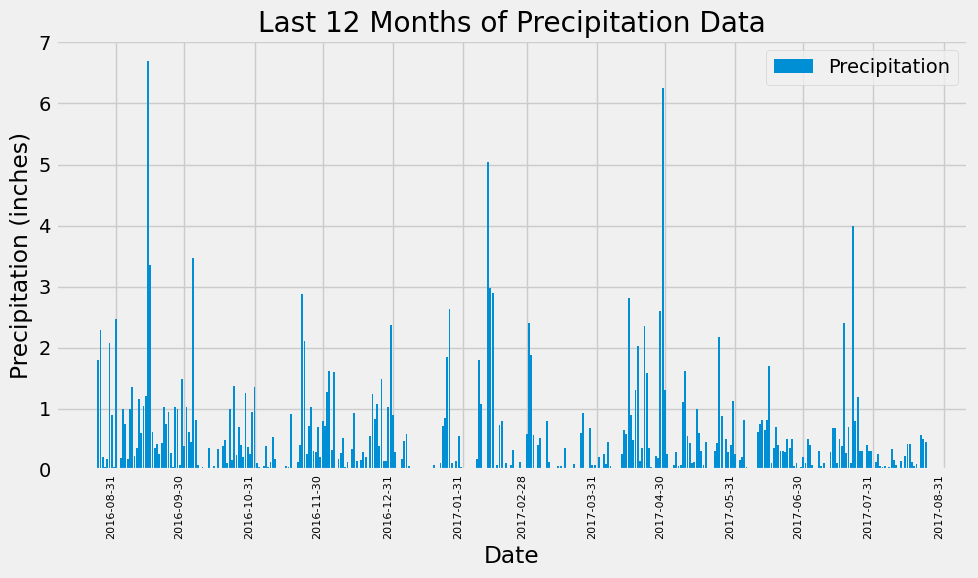

In [196]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = recent_date.date


# Calculate the date one year from the last date in data set.
one_year_prior = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
one_year_prior_str = one_year_prior.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_prior_str).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_values(by='Date')

# Define the start of each month
month_starts = pd.date_range(df.index.min(), df.index.max(), freq='MS')
unique_months = df.resample('M').sum().index

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(df.index, df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation Data')
plt.xticks(unique_months, rotation=90, ha='right', fontsize=8) 
plt.tight_layout()
plt.legend()
plt.show()

In [197]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['Precipitation'].describe()
print(summary_stats)


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [198]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).count()
print(total_stations)

9


In [199]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [200]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]


temperature_stats_query = session.query(
    func.min(Measurement.tobs).label('lowest_temperature'),
    func.max(Measurement.tobs).label('highest_temperature'),
    func.avg(Measurement.tobs).label('average_temperature')
).filter(Measurement.station == most_active_station).first()

#Calculated statistics from the query 
lowest_temperature = temperature_stats_query.lowest_temperature
highest_temperature = temperature_stats_query.highest_temperature
average_temperature = temperature_stats_query.average_temperature

# Print the calculated statistics
print(f"Most Active Station: {most_active_station}")
print(f"Lowest Temperature: {lowest_temperature}")
print(f"Highest Temperature: {highest_temperature}")
print(f"Average Temperature: {average_temperature}")


Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


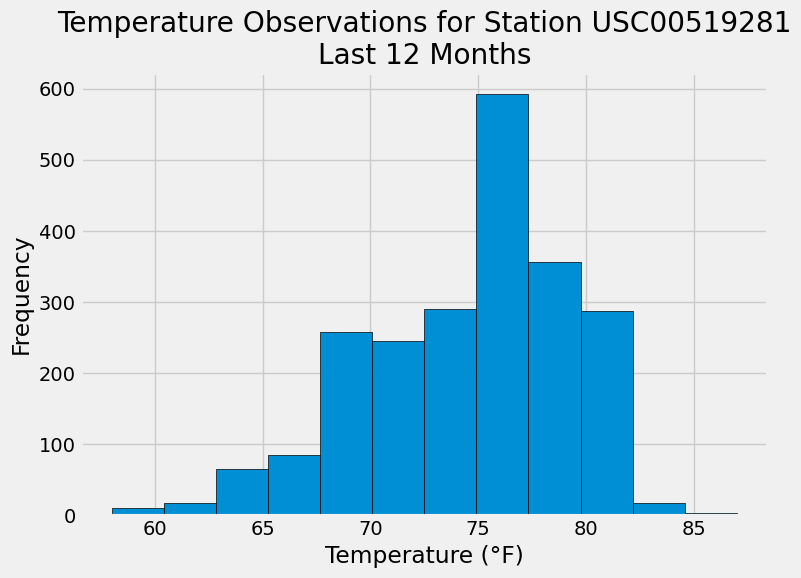

In [201]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= one_year_prior_str).all()

temp_df = pd.DataFrame(temp_data, columns=['Date', 'Temperature'])

plt.figure(figsize=(8, 6))
plt.hist(temp_df['Temperature'], bins=12, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station}\nLast 12 Months')
plt.tight_layout()
plt.legend
plt.show()

# Close Session

In [202]:
# Close Session
session.close()